# 温度建模分析 2018-06-11

In [1]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

## 1  概述

除去齿轮箱与发电机系统内的温度测点，信息系统内的102个测点，剩余的温度测点有12个，具体如下所示：

* r39- 变流器网测模块温度
* r40- 变流器机侧模块温度
* r58- 主轴承温度
* r76- 桨叶1电机温度
* r78- 桨叶2电机温度
* r80- 桨叶3电机温度
* r81- 塔底控制柜温度
* r82- 塔底温度
* r83- 机舱控制柜温度
* r84- 机舱温度
* r85- 箱变变压器温度
* r86- 环境温度

这些温度之间有什么关系，是否需要单独分系统单独建模，下面将进行详细的分析

## 2 数据处理

In [1]:
# 读取数据
import os
import pandas as pd
import numpy as np

FILE_PATH = r'D:\00_工作日志\O\2018-06\赤峰项目故障\data\赤峰二期5min数据'
FILE_NAME = 'CFEQ_wt1_5min_201601-201712.csv'

os.chdir(FILE_PATH)
df = pd.read_csv(FILE_NAME, index_col=0)
df.index = pd.to_datetime(df.index)
df.shape

(208512, 101)

### 2.1 筛选变量

* 温度变量： 从信息系统102个测点中，筛选出除齿轮箱与发电机系统外所有的温度变量
* 其它变量： 筛选出功率、风速、发电机转速变量作为协助分析
##### 综合筛选的变量有：['r18',  'r43',  'r47',  'r39',  'r40',  'r58',  'r76',  'r78',  'r80',  'r81',  'r82',  'r83',  'r84',  'r85',  'r86']

### 2.2 筛选正常发电状态

* 功率- r18： r18 > 5
* 转速- r47： r47 > 0

In [2]:
cols = ['r18', 'r43', 'r47', 'r57', 'r39', 'r40', 'r58', 'r76', 'r78', 'r80', 'r81', 'r82', 'r83', 'r84', 'r85', 'r86']
df = df.loc[:, cols]
df = df[df['r18'] > 5] # 筛选功率 > 5
df = df[df['r57'] > 0] # 筛选功率 > 5
df.shape

(127657, 16)

In [4]:
df.head()

,r18,r43,r47,r57,r39,r40,r58,r76,r78,r80,r81,r82,r83,r84,r85,r86
r1,,,,,,,,,,,,,,,,
2016-01-01 07:40:00,877.0,9.458,1641.0,12.58,7.0,11.0,NaN,-27.9,-27.9,-27.9,7.2,0.0,6.0,3.0,NaN,-3.0
2016-01-01 07:45:00,872.0,13.718,1652.0,12.63,6.0,10.0,NaN,-24.9,-24.9,-23.9,7.2,0.0,6.0,4.0,NaN,-3.0
2016-01-01 07:50:00,877.0,10.786,1669.0,12.77,6.0,10.0,NaN,-22.9,-22.9,-22.9,7.2,1.0,6.0,5.0,NaN,-3.0
2016-01-01 07:55:00,870.0,10.248,1688.0,12.93,6.0,10.0,NaN,-20.9,-20.9,-20.9,7.2,1.0,6.0,7.0,NaN,-3.0
2016-01-01 08:00:00,875.0,10.549,1627.0,12.53,6.0,10.0,NaN,-19.9,-19.9,-19.9,7.2,1.0,7.0,8.0,NaN,-3.0


### 2.3 查看数据信息

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122133 entries, 2016-01-01 07:40:00 to 2017-12-31 23:55:00
Data columns (total 16 columns):
r18    122133 non-null float64
r43    122133 non-null float64
r47    122133 non-null float64
r57    122133 non-null float64
r39    122133 non-null float64
r40    122133 non-null float64
r58    121679 non-null float64
r76    122133 non-null float64
r78    122133 non-null float64
r80    122133 non-null float64
r81    122133 non-null float64
r82    122133 non-null float64
r83    122133 non-null float64
r84    122133 non-null float64
r85    786 non-null float64
r86    122133 non-null float64
dtypes: float64(16)
memory usage: 15.8 MB


##### 可见
* r85- 箱变变压器温度: 数据太少，删除此列，暂时不考虑此温度
* r58- 主轴承温度：数据缺失，删除缺失行

In [3]:
# 删除r85列，并删除r58缺失数据的行
df = df.drop(['r85'], axis=1)
df = df.dropna(how='any', axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127272 entries, 2016-01-05 07:00:00 to 2017-12-31 23:55:00
Data columns (total 15 columns):
r18    127272 non-null float64
r43    127272 non-null float64
r47    127272 non-null float64
r57    127272 non-null float64
r39    127272 non-null float64
r40    127272 non-null float64
r58    127272 non-null float64
r76    127272 non-null float64
r78    127272 non-null float64
r80    127272 non-null float64
r81    127272 non-null float64
r82    127272 non-null float64
r83    127272 non-null float64
r84    127272 non-null float64
r86    127272 non-null float64
dtypes: float64(15)
memory usage: 15.5 MB


### 2.4 查看数据描述

In [8]:
df.describe()

,r18,r43,r47,r57,r39,r40,r58,r76,r78,r80,r81,r82,r83,r84,r86
count,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000,121679.000000
mean,667.985158,6.431101,1392.102885,10.661899,19.430027,21.018435,22.953815,-4.576017,-4.862195,-5.164253,18.187390,11.916590,18.261086,13.868072,4.733138
std,569.413094,2.760023,269.298824,2.062750,12.392491,12.684271,8.452462,14.582823,14.403657,14.256841,11.213413,12.001525,9.776234,10.423375,12.666969
min,6.000000,0.608000,1.000000,0.030000,-15.900000,-12.900000,-8.000000,-50.900000,-49.900000,-52.900000,-14.000000,-20.000000,-12.000000,-20.000000,-30.000000
25%,218.000000,4.395000,1104.000000,8.440000,9.000000,11.000000,16.300000,-13.900000,-14.900000,-14.900000,8.000000,1.000000,11.200000,7.000000,-6.000000
50%,485.000000,6.005000,1351.000000,10.350000,20.000000,22.000000,22.800000,-5.900000,-5.900000,-5.900000,17.000000,11.800000,19.000000,14.400000,5.000000
75%,950.000000,7.947000,1688.000000,12.930000,30.000000,31.000000,30.500000,6.000000,6.000000,5.000000,28.200000,22.500000,26.100000,22.200000,15.600000
max,2114.000000,27.752000,1929.000000,14.770000,50.000000,56.000000,42.000000,33.000000,29.000000,30.000000,43.900000,39.800000,40.000000,39.200000,36.000000


### 2.5 查看数据直方图

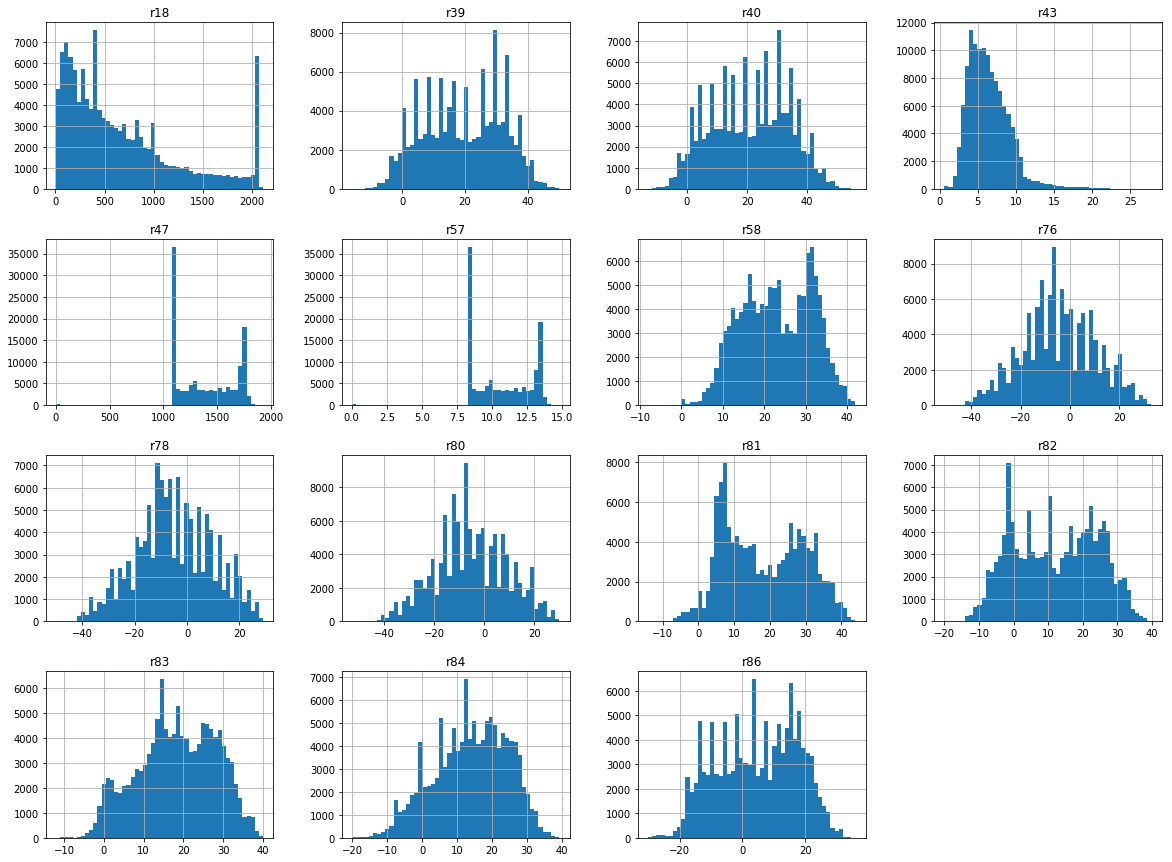

In [9]:
%matplotlib inline   
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()

### 2.6 查看温度数据之间的相关性

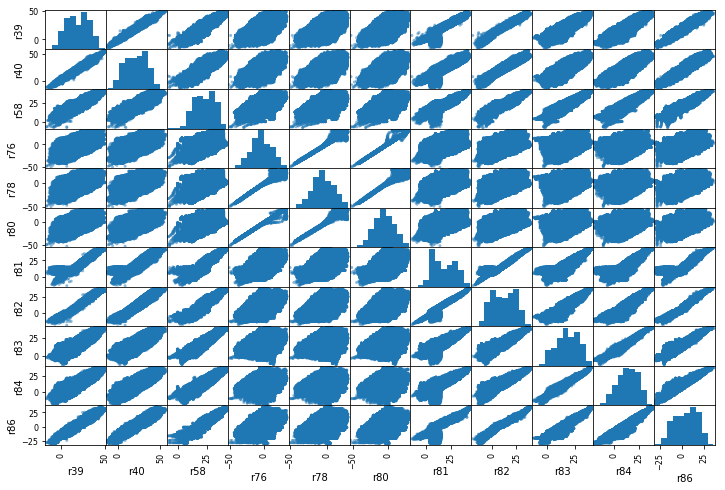

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["r39", "r40", "r58", "r76", "r78", "r80", "r81", "r82", "r83", "r84", "r86"]
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

#### 从上图可以得到以下几点结论
* r81（塔底控制柜温度）有点异常
* r76、r78、r80三者相关性很强，但与其它温度相关性较弱,温度模型，他们3个可以一起
* 剩余温度之间相关性较强

## 变桨电机3个温度图展示

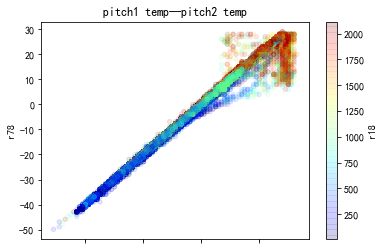

In [26]:
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams['font.family'] = 'Kaiti' #黑体
# matplotlib.rcParams['font.size'] = '10'
plt.rcParams['axes.unicode_minus']=False # 解决负值不显示


df.plot(kind="scatter", x="r76",y="r78",alpha=0.1,
       c="r18", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.title('pitch1 temp—pitch2 temp')
plt.show()

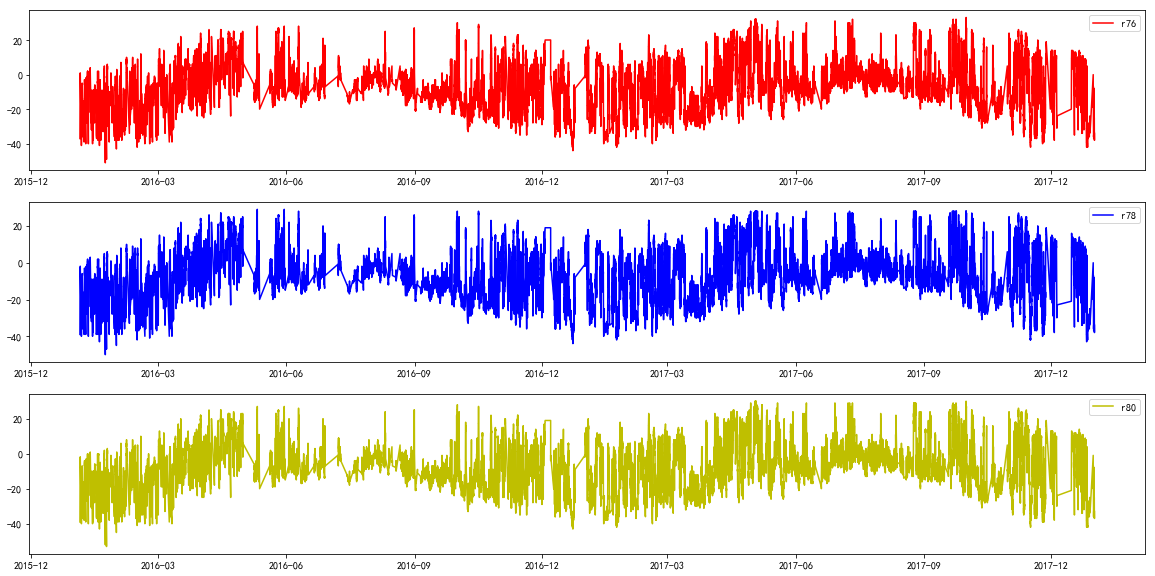

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(df['r76'], alpha=1, label = 'r76',color='r')
plt.legend()
plt.subplot(3,1,2)
plt.plot(df['r78'], alpha=1, label = 'r78',color='b')
plt.legend()
plt.subplot(3,1,3)
plt.plot(df['r80'], alpha=1, label = 'r80',color='y')
plt.legend()
plt.show()

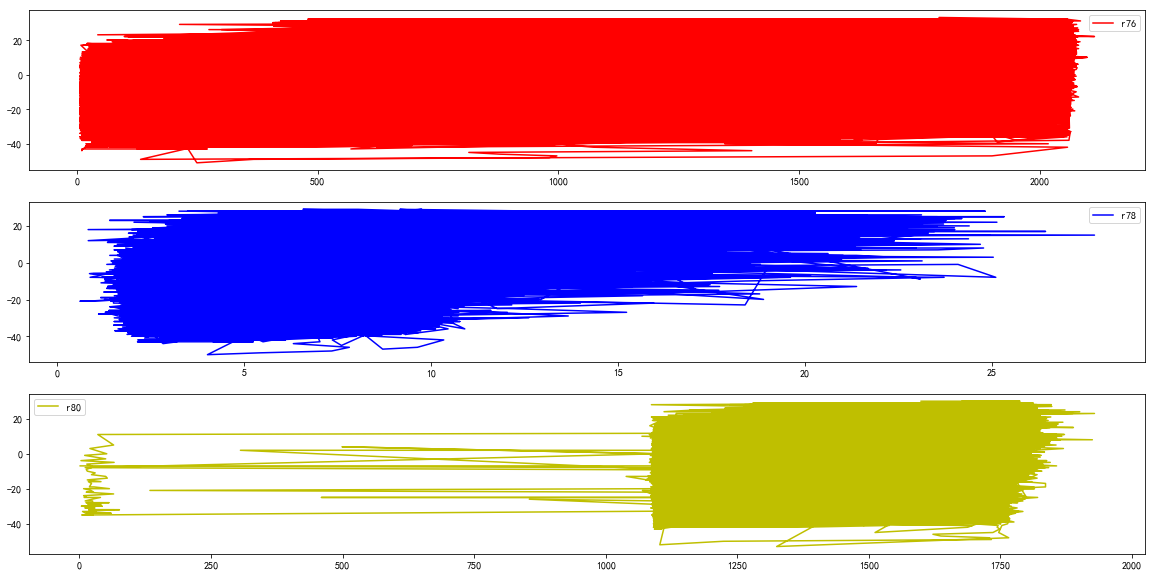

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(df['r18'].values, df['r76'].values, alpha=1, label = 'r76',color='r')
plt.legend()
plt.subplot(3,1,2)
plt.plot(df['r43'].values, df['r78'].values, alpha=1, label = 'r78',color='b')
plt.legend()
plt.subplot(3,1,3)
plt.plot(df['r47'].values, df['r80'].values, alpha=1, label = 'r80',color='y')
plt.legend()
plt.show()

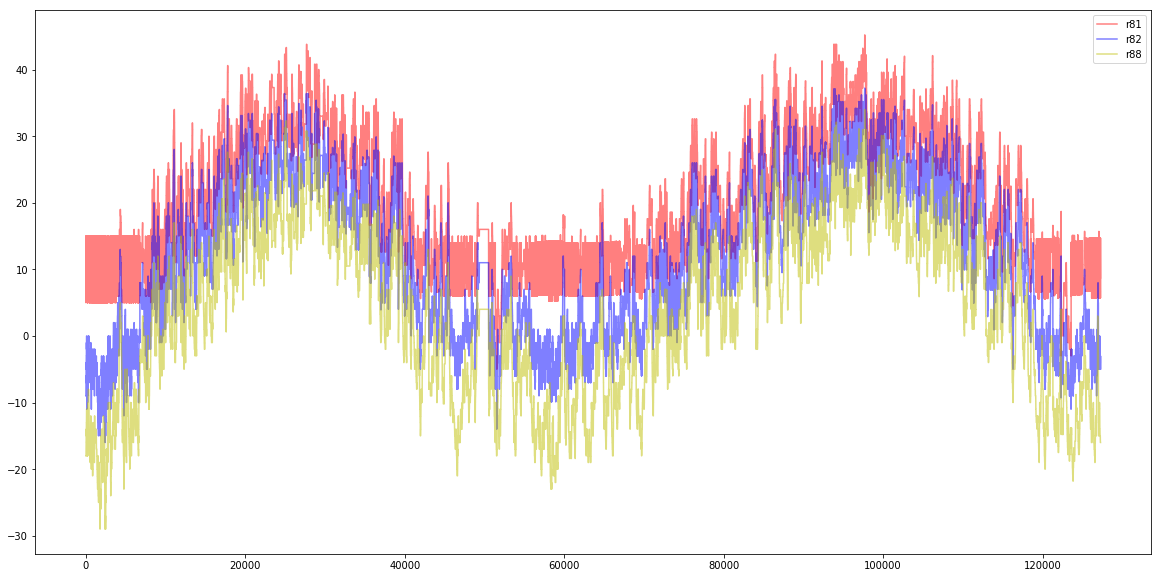

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df['r81'].values, alpha=0.5, label = 'r81',color='r')
plt.plot(df['r82'].values, alpha=0.5, label = 'r82',color='b')
plt.plot(df['r86'].values, alpha=0.5, label = 'r88',color='y')
plt.legend()
plt.show()

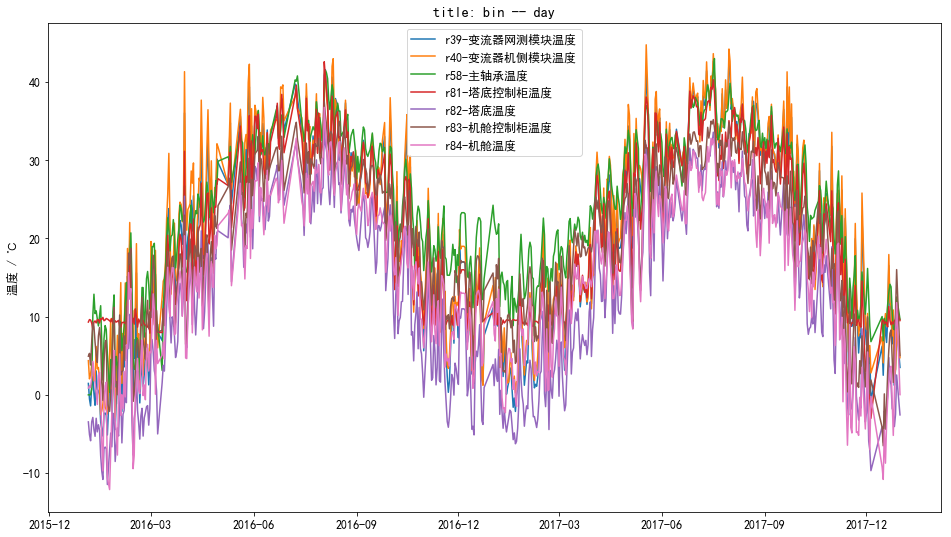

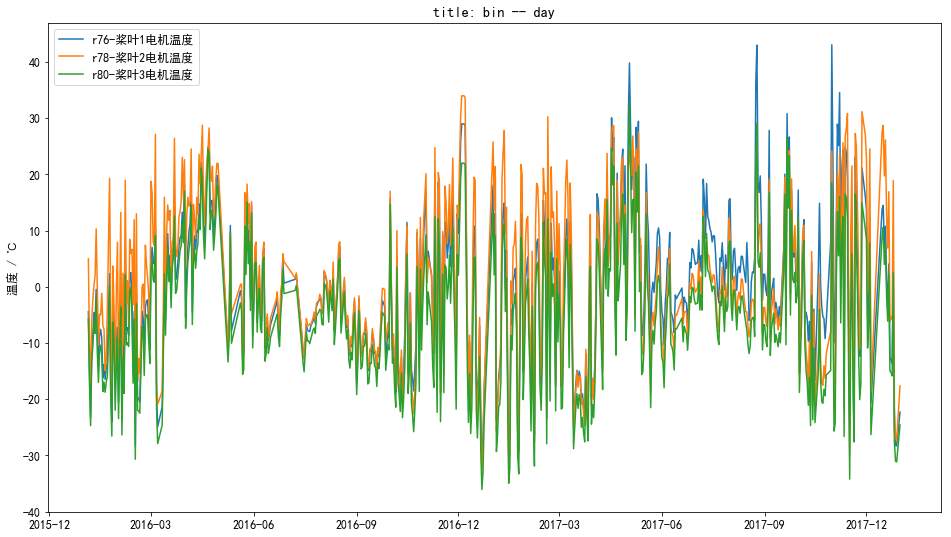

In [41]:
# 增加天列
df['year_day'] = [str(x)[: 10] for x in df.index]
gt_mean = df.groupby(df['year_day']).mean()

# 画图1
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei' #黑体
matplotlib.rcParams['font.size'] = '12' #包括坐标轴字号均改变
plt.rcParams['axes.unicode_minus']=False #解决坐标轴负值不显示问题

plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r39'].values, label='r39-变流器网测模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r40'].values, label='r40-变流器机侧模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r58'].values, label='r58-主轴承温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r81'].values, label='r81-塔底控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r82'].values, label='r82-塔底温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r83'].values, label='r83-机舱控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r84'].values, label='r84-机舱温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- day')
plt.show()

# 画图2
plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r76'].values, label='r76-桨叶1电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r78'].values, label='r78-桨叶2电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r80'].values, label='r80-桨叶3电机温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- day')
plt.show()


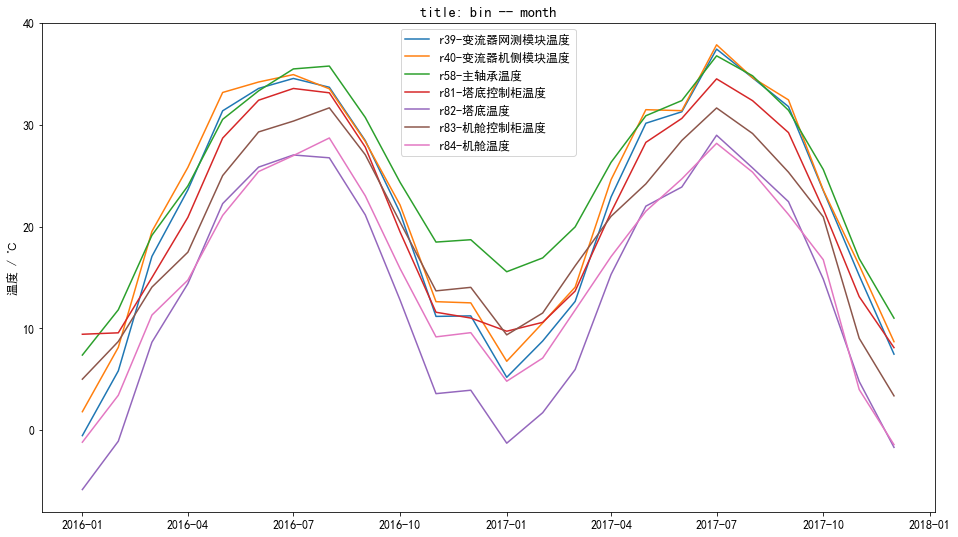

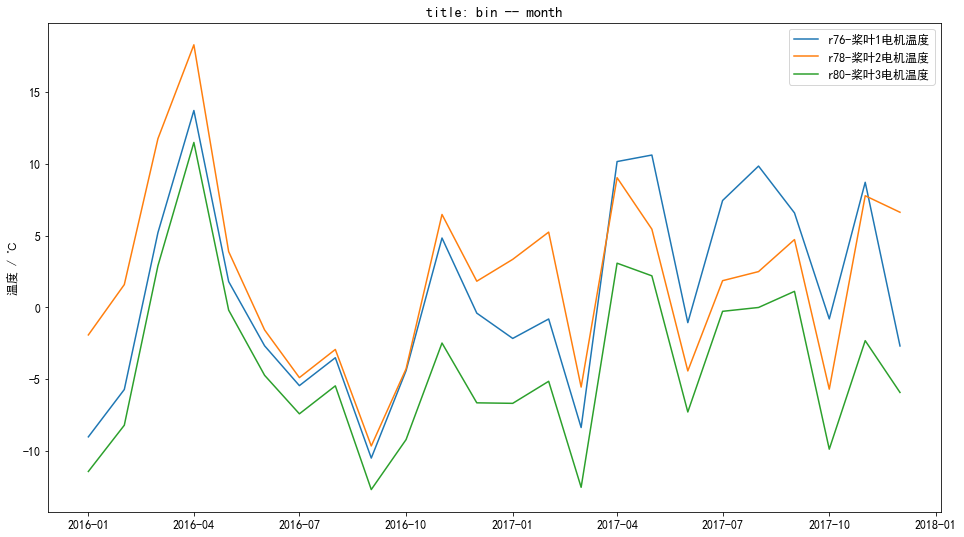

In [40]:
# 增加月列
df['year_month'] = [str(x)[: 7] for x in df.index]
gt_mean = df.groupby(df['year_month']).mean()

# 画图1
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei' #黑体
matplotlib.rcParams['font.size'] = '12' #包括坐标轴字号均改变
plt.rcParams['axes.unicode_minus']=False #解决坐标轴负值不显示问题

plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r39'].values, label='r39-变流器网测模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r40'].values, label='r40-变流器机侧模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r58'].values, label='r58-主轴承温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r81'].values, label='r81-塔底控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r82'].values, label='r82-塔底温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r83'].values, label='r83-机舱控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r84'].values, label='r84-机舱温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- month')
plt.show()

# 画图2
plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r76'].values, label='r76-桨叶1电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r78'].values, label='r78-桨叶2电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r80'].values, label='r80-桨叶3电机温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- month')
plt.show()

